## 대규모 데이터 handling
* MovieLens 20M 데이터는 138,494명의 user가 131,263개의 영화에 대해 평가한 약 2,000만개의 데이터를 포함하고 있다. 이런 데이터를 처리 할 때 가장 흔하게 발생하는 문제가 메모리 부족이다.
* 위 데이터를 full matrix로 변환시 18,179,137,922 개의 원소를 갖는 매트릭스가 필요하다.
* 추천 시스템에서 사용되는 대부분의 데이터는 full matrix로 변환하면 많은 원소가 비어있는 sparse matrix이다. 
* MovieLens 100K 데이터를 full matrix로 변환해 그 중 rating 값을 가지는 원소의 개수는 약 0.6%이다. MovieLens 20M 의 경우 0.1% 밖에 되지 않는다.



### Sparse Matrix
* 다루고자 하는 데이터가 Sparse matrix인 경우 이를 full matrix로 저장하는 대신에 행렬의 원소 중 실제 값을 가지는 것만 그 인덱스와 같이 저장해서 사용하는 것이 훨씬 더 효율적일 것 이다.
* Sparse matrix는 데이터를 저장하거나 읽어올 떄마다 값이 존재하는지 확인해서 그에 맞는 처리를 해야 하므로 데이터 처리의 overhead cost가 크다는 단점이 있다. 그래서 데이터가 그렇게 희박하지 않는 경우에 위의 방식을 이용한다면 공간 절약의 이점보다 속도 저하의 단점이 더 커진다.
* Python에서는 Scipy 클래스의 하나로 sparse matrix가 구현되어 있다.
* 다양한 Scipy sparse matrix class
    - bsr_matrix : Block Sparse Row matrix
    - coo_matrix : A sparse matrix in COOrdinate format.
    - csc_matrix : Compressed Sparse Column matrix
    - csr_matrix : Compressed Sparse Row matrix
    - dia_matrix : Sparse matrix with DIAgonal storage
    - dok_matrix : Dictionary Of Keys based sparse matrix.
    - lil_matrix : Row-based linked list sparse matrix

* 아래 예제에선 row slicing에 적합한 csr_matrix를 사용하기로 한다.
* 참고 : https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/


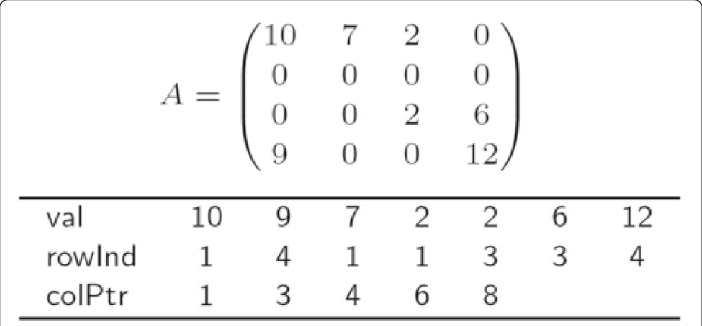

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_repo = '/content/drive/MyDrive/recommender_system/practice/'

from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [ ]:
ratings = {
    'user_id' : [1,2,4],
    'movie_id' : [2,3,7],
    'rating' : [4,3,1]
}
ratings = pd.DataFrame(ratings)

# full matrix using pandas pivot
rating_matrix = ratings.pivot(index='user_id', columns = 'movie_id', values='rating').fillna(0)
full_matrix1 = np.array(rating_matrix)
print(full_matrix1)

[[4. 0. 0.]
 [0. 3. 0.]
 [0. 0. 1.]]


In [ ]:
data = np.array(ratings['rating'])
row_indices = np.array(ratings['user_id'])
col_indices = np.array(ratings['movie_id'])
rating_matrix = csr_matrix((data, (row_indices, col_indices)), dtype = int)
print(rating_matrix)

  (1, 2)	4
  (2, 3)	3
  (4, 7)	1


In [ ]:
print(rating_matrix*2)
print()
print(rating_matrix.T)
print()
print(rating_matrix.dot(rating_matrix.T))

  (1, 2)	8
  (2, 3)	6
  (4, 7)	2

  (2, 1)	4
  (3, 2)	3
  (7, 4)	1

  (1, 1)	16
  (2, 2)	9
  (4, 4)	1


In [ ]:
full_matrix2 = rating_matrix.toarray()
print(full_matrix2)

[[0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


In [5]:
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'ratings-20m.csv', sep=',', names = r_cols, encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']]

In [6]:
ratings.shape

(20000263, 3)

In [ ]:
# memory error
R_temp = ratings.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)

ValueError: ignored

In [ ]:
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations , verbose = True):
        self.R = ratings
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
        
    def rmse(self):
        xs, ys = self.R.nonzero() #평점이 0이 아닌 data point의 index
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x,y) # 행렬 분해를 이용한 예측값
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    def train(self):
        # initializing user-feature and moive-feature matrix
        self.P = np.random.normal(scale=1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size = (self.num_items, self.K))

        #initializing bias term
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        #List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i,j, self.R[i,j]) for i,j in zip(rows, columns)]

        # stochastic gradient descent algorithm
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) %10 ==0:
                    print("Iteration: %d ; Train RMSE = %.4f" % (i+1, rmse))
        return training_process

    def get_prediction(self, i,j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction

    def sgd(self):
        for i,j,r in self.samples:
            prediction = self.get_prediction(i,j)
            e = (r-prediction)
            self.b_u[i] += self.alpha * (e- self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e- self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])



class MF_test(MF):
    def __init__(self, ratings, K, alpha, beta, iterations, verbose = True):
        self.R = ratings
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

        # item_id_index = []
        # index_item_id = []
        # for i , one_id in enumerate(ratings):
        #     item_id_index.append([one_id, i]) # item의 id와 index를 저장해 id로 item을 mapping 할 수 있도록 함
        #     index_item_id.append([i, one_id]) # 반대로 item으로 id를 mapping할 수 있도록 함

        # self.item_id_index = dict(item_id_index)
        # self.index_item_id = dict(index_item_id)
        # user_id_index = []
        # index_user_id = []
        # for i,one_id in enumerate(ratings.T): 
        #     user_id_index.append([one_id, i]) # user id 로 index 를 mapping 할 수 있도록 함
        #     index_user_id.append([i, one_id]) # index 로 user id를 mapping 할 수 있도록 함
        # self.user_id_index = dict(user_id_index)
        # self.index_user_id = dict(index_user_id)

    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):
            x,y,z = ratings_test.iloc[i]
            test_set.append([x,y,z])
            self.R[x,y] = 0
        self.test_set = test_set
        return test_set

    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error / len(self.test_set))

    def test(self):
        self.P = np.random.normal(scale=1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size = (self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        rows, columns = self.R.nonzero()
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows,columns)]
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1,rmse1, rmse2))
            if self.verbose:
                if (i+1) %50 ==0:
                    print("Iteration: %d  : Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id, self.item_id)

    def full_predictions(self):
        return self.b + self.b_u[:, np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_rating(rating_matrix,random_seed = 42):
    x= rating_matrix.copy()
    y= rating_matrix['user_id']
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .25, stratify = y, random_state = random_seed)
    cold_start = X_test.loc[~X_test['movie_id'].isin(X_train['movie_id'].unique()), 'movie_id']
    X_train = X_train.append(X_test.loc[X_test['movie_id'].isin(cold_start.values), :])
    X_test = X_test.drop(cold_start.index)
    return X_train, X_test

In [ ]:
X_train, X_test = train_test_rating(ratings)
data = np.array(X_train['rating'])
row_indices = np.array(X_train['user_id'])
col_indices = np.array(X_train['movie_id'])
rating_matrix = csr_matrix((data, (row_indices, col_indices)), dtype = int)

In [ ]:
R_temp = rating_matrix.copy()
mf = MF_test(R_temp, K=30, alpha=.001, beta=.02, iterations=200, verbose = True)
test_set = mf.set_test(X_test)
results = mf.test()

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


KeyboardInterrupt: ignored

In [2]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 277kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617611 sha256=c7e69bc3144ea9e472b6239394cf32445862e39c9e1313ba8f70606cb49da727
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [3]:
from surprise import Reader, Dataset
from surprise import SVDpp

In [7]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)

In [8]:
from surprise.model_selection import cross_validate, train_test_split
trainset, testset = train_test_split(data, test_size=.25)

In [9]:
mf_ = SVDpp()
mf_.fit(trainset)

KeyboardInterrupt: ignored

In [ ]:
y_pred = mf_.test(testset)
accuracy.rmse(y_pred)